### Data Preprocessing

In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import json

from helpers.facedetection import extractFaces
from helpers.UTKFaceDataprocessing import UTKFaceProcessing, UTKFaceTrainTestSplit, UTKFaceDataDistribution
from models.AgeGenderModel import AGmodel

In [5]:
fldr = "./UTKFace_10k"
images, labels, ages, genders, images_o = UTKFaceProcessing(fldr)

Importing labels: 100%|█████████████████████████████████████| 9780/9780 [00:00<00:00, 325992.54it/s]


In [4]:
X_train, X_test, Y_train, Y_test= UTKFaceTrainTestSplit(images, labels, testSize=0.25)
Y_train_2=[Y_train[:,1],Y_train[:,0]]
Y_test_2=[Y_test[:,1],Y_test[:,0]]

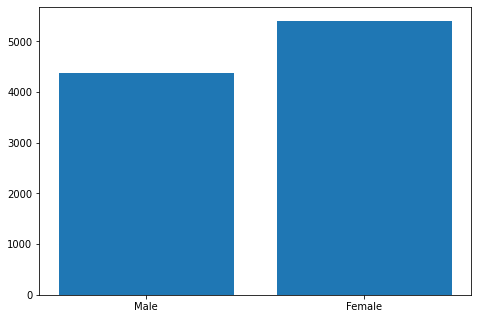

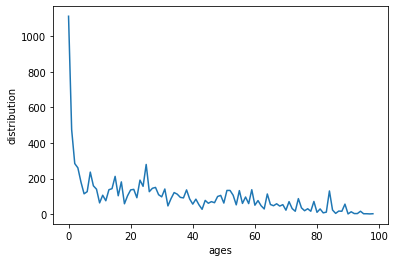

In [5]:
UTKFaceDataDistribution(genders, ages)

### Model

In [3]:
Model=AGmodel((48,48,3))

In [4]:
Model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 48, 48, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 48, 48, 32)   0           dropout[0][0]                    
______________________________________________________________________________________________

### Training

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [9]:
fle_s='./saved/Age_sex_detection_UTKFace10k.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
Early_stop = EarlyStopping(patience=75, monitor='val_loss',restore_best_weights=True),
callback_list = [checkpointer,Early_stop]

In [83]:
History=Model.fit(X_train,Y_train_2,batch_size=64,validation_data=(X_test,Y_test_2),epochs=250,callbacks=[callback_list])

Epoch 1/250
115/115 [==============================] - 61s 522ms/step - loss: 23.1763 - sex_out_loss: 0.7274 - age_out_loss: 22.2089 - sex_out_accuracy: 0.5278 - age_out_accuracy: 0.1088 - val_loss: 20.8687 - val_sex_out_loss: 0.6864 - val_age_out_loss: 20.0066 - val_sex_out_accuracy: 0.5595 - val_age_out_accuracy: 0.1088

Epoch 00001: val_loss improved from inf to 20.86873, saving model to ./saved\Age_sex_detection_UTKFace10k.h5
Epoch 2/250
115/115 [==============================] - 61s 528ms/step - loss: 20.0576 - sex_out_loss: 0.6867 - age_out_loss: 19.1940 - sex_out_accuracy: 0.5524 - age_out_accuracy: 0.1127 - val_loss: 17.4690 - val_sex_out_loss: 0.6823 - val_age_out_loss: 16.5773 - val_sex_out_accuracy: 0.5595 - val_age_out_accuracy: 0.1039

Epoch 00002: val_loss improved from 20.86873 to 17.46897, saving model to ./saved\Age_sex_detection_UTKFace10k.h5
Epoch 3/250
115/115 [==============================] - 60s 525ms/step - loss: 15.1558 - sex_out_loss: 0.6671 - age_out_loss: 14

### Saving model and data

In [ ]:
# Save path
save_dr = './saved/'
# Get the dictionary containing each metric and the loss for each epoch
history_dict = History.history
# Save it under the form of a json file
json.dump(history_dict, open(save_dr+'UTKFace23k_history.json', 'w'))

### Loadingn model and data

In [22]:
Model = tf.keras.models.load_model('./saved/Age_sex_detection_UTKFace23k.h5')
History = json.load(open('./saved/UTKFace23k_history.json', 'r'))

### Evaluate model

In [23]:
Model.evaluate(X_test,Y_test_2)

77/77 [==============================] - 5s 58ms/step - loss: 5.7327 - sex_out_loss: 0.2700 - age_out_loss: 4.6352 - sex_out_sex_out_accuracy: 0.8720 - age_out_age_out_accuracy: 0.1084: 3s - loss: 5.8827 - sex_out_loss: 0.2659 - age_out_loss: 4.7892 - sex_out_sex_o


[5.732713222503662,
 0.2699747383594513,
 4.635166645050049,
 0.8719836473464966,
 0.10838446021080017]

In [93]:
pred=Model.predict(X_test)

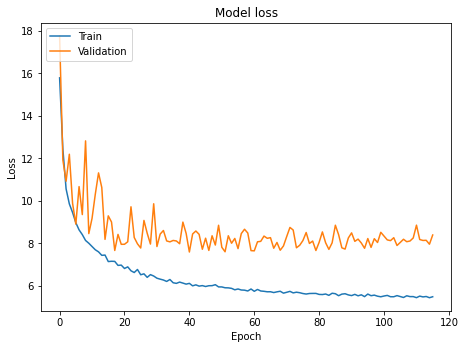

In [144]:
plt.plot(History['loss'])
plt.plot(History['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25, wspace=0.35)       

### For gender

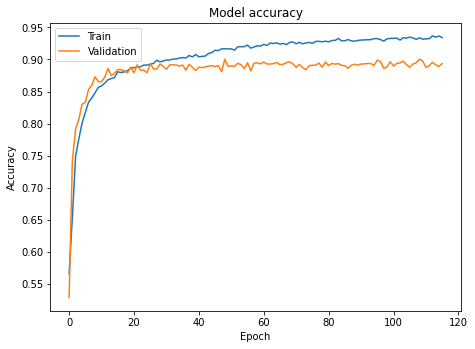

In [145]:
plt.plot(History['sex_out_accuracy'])
plt.plot(History['val_sex_out_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

### For age

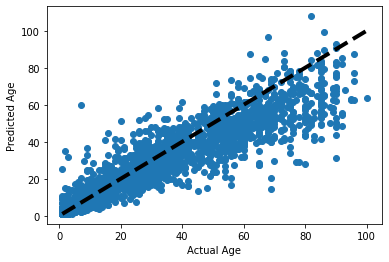

In [146]:
fig, ax = plt.subplots()
ax.scatter(Y_test_2[1], pred[1])
ax.plot([Y_test_2[1].min(),Y_test_2[1].max()], [Y_test_2[1].min(), Y_test_2[1].max()], 'k--', lw=4)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age')
plt.show()

### For gender

In [97]:
i=0
Pred_l=[]
while(i<len(pred[0])):

  Pred_l.append(int(np.round(pred[0][i])))
  i+=1

In [98]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

In [99]:
report=classification_report(Y_test_2[0], Pred_l)

In [100]:
print(report)

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1077
           1       0.88      0.81      0.85      1368

    accuracy                           0.83      2445
   macro avg       0.83      0.84      0.83      2445
weighted avg       0.84      0.83      0.84      2445



In [101]:
results = confusion_matrix(Y_test_2[0], Pred_l)

<AxesSubplot:>

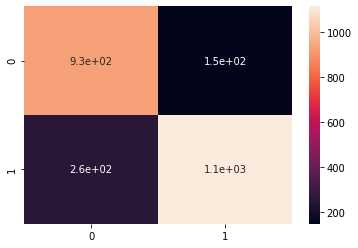

In [102]:
import seaborn as sns
sns.heatmap(results, annot=True)

In [12]:
def test_image(index,images, genders, ages ,Model, showImg=False, withLabel=False):
    ages_f = np.array(ages)
    genders_f = np.array(genders)
    
    image_test= np.array(images[index])/255
    pred_1=Model.predict(np.array([image_test]))

    sex_f=['Male','Female']
    age=int(np.round(pred_1[1][0]))
    sex=int(np.round(pred_1[0][0]))
    
    if withLabel:
        print(f"Predicted Age: {str(age)}, Actual age: {str(ages_f[index])}")
        print(f"Predicted Sex: {sex_f[sex]}, Actual sex: {sex_f[genders_f[index]]}")
    else:
        print(f"Predicted Age: {str(age)}")
        print(f"Predicted Sex: {sex_f[sex]}")
        
    if showImg:
        plt.imshow(images_f[index])
        plt.show()
        plt.clf()
    return age, ages_f[index], sex, genders_f[index]

### Testing
Testing random images with error bound for correctness -5 and +5 years for age.

In [24]:
# test 20 random images
correct_age = 0
correct_sex = 0
error_bound = 5
results = []
numTest = 100
for i in range(numTest):
    age = []
    gender = []
    res = []
    
    img_index = np.random.randint(1, len(images))
    print(f"############# Image no. {i+1} #############")
    pred_age, act_age, pred_sex, act_sex = test_image(img_index,images, genders, ages, Model, withLabel=True)
    
    age.append(pred_age)
    age.append(act_age)
    age.append(0)
    
    for e in range(error_bound):
        if pred_age+e == act_age or pred_age-e == act_age:
#             correct_age += 1
            age[2] = 1

    gender.append(pred_sex)
    gender.append(act_sex)
    if pred_sex == act_sex:
        correct_sex += 1
        gender.append(1)
    else:
        gender.append(0)
    
    res.append(gender)
    res.append(age)
    results.append(res)
    
print("#######################################################################")
print(f"Accuracy: age {(correct_age/numTest)*100}% - sex {(correct_sex/numTest)*100}%")
    
    

############# Image no. 1 #############
Predicted Age: 1, Actual age: 2
Predicted Sex: Female, Actual sex: Female
############# Image no. 2 #############
Predicted Age: 3, Actual age: 2
Predicted Sex: Female, Actual sex: Female
############# Image no. 3 #############
Predicted Age: 40, Actual age: 28
Predicted Sex: Male, Actual sex: Male
############# Image no. 4 #############
Predicted Age: 54, Actual age: 62
Predicted Sex: Female, Actual sex: Female
############# Image no. 5 #############
Predicted Age: 2, Actual age: 2
Predicted Sex: Female, Actual sex: Male
############# Image no. 6 #############
Predicted Age: 9, Actual age: 10
Predicted Sex: Male, Actual sex: Male
############# Image no. 7 #############
Predicted Age: 1, Actual age: 1
Predicted Sex: Female, Actual sex: Female
############# Image no. 8 #############
Predicted Age: 63, Actual age: 75
Predicted Sex: Female, Actual sex: Female
############# Image no. 9 #############
Predicted Age: 33, Actual age: 32
Predicted Sex: Ma

In [25]:
results = np.array(results)
sex_p = results[:,0]
ages_p = results[:,1]
acc_age = (np.sum(ages_p, axis=0)/ages_p.shape[0])[2]
acc_sex = (np.sum(sex_p, axis=0)/sex_p.shape[0])[2]
(acc_sex, acc_age)


(0.88, 0.57)

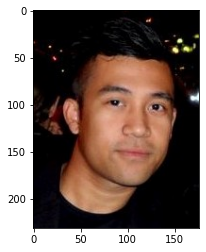

Predicted Age: 29
Predicted Sex: Male


(29, 100, 0, 1)

In [26]:
import cv2 as cv
img = cv.imread("./images/test1_crop.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_resized = cv.resize(img,(48,48))
plt.imshow(img)
plt.show()
test_images = [img_resized]
test_images_2 = [img_resized/255]
test_image(0, test_images, genders, ages, Model)

Predicted Age: 29
Predicted Sex: Male


(29, 100, 0, 1)

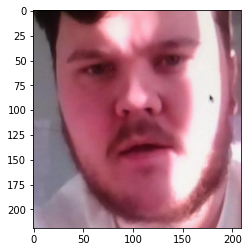

In [27]:
img = cv.imread("./images/mnsosk.PNG")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_resized = cv.resize(img,(48,48))
plt.imshow(img)
test_images = [img_resized]
test_images_2 = [img_resized/255]
test_image(0, test_images, gender, ages, Model)

Predicted Age: 21
Predicted Sex: Female


(21, 100, 1, 1)

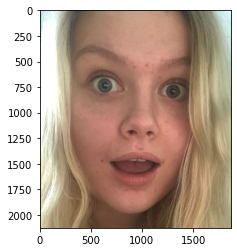

In [28]:
img = cv.imread("./images/elsa_crop.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img_resized = cv.resize(img,(48,48))
plt.imshow(img)
test_images = [img_resized]
test_images_2 = [img_resized/255]
test_image(0, test_images, gender, ages, Model, withLabel=False)

### Testing with face detection model

In [10]:
# Extract faces from imaga
faces = extractFaces('./images/grouppic.jpg', scaleFactor=1.2, minNeighbours=5)

C:\Users\cpang\D7041E_mini_project\helpers\facedetection.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  faces_return = np.array(faces_list)


In [11]:
for face in faces:
    # resize img
#     img = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (48, 48))

    # show face
    plt.imshow(img)
    plt.show()
    
    # predict gender and age
    test_image(0, [img_resized],genders, ages, Model)

NameError: name 'img' is not defined